# Introduction to tracking data in NFL

Using data from [NFL Next Gen Stats highlight](https://nextgenstats.nfl.com/highlights/play-list) , we can get a selected sample of tracking data from the webpage. Even though the sample is small, it's still really useful to build a prototype for application to data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch

In [3]:
tracking_data = pd.read_csv('Highlight_19_post.csv', index_col=[0])
tracking_data.head()

,IsOnOffense,defTeam,dir,displayName,gsisId,nflId,o,position,possTeam,s,time,x,y,game_id,play_id,playType,event_name
0,False,PHI,62.27,Malcolm Jenkins,00-0026990,79848.0,91.32,SS,SEA,0.73,2020-01-05 23:38:35.000,58.91,24.80,2020010501,2688,play_type_pass,NaN
1,False,PHI,60.92,Malcolm Jenkins,00-0026990,79848.0,91.32,SS,SEA,0.73,2020-01-05 23:38:35.100,58.97,24.83,2020010501,2688,play_type_pass,huddle_start_offense
2,False,PHI,62.36,Malcolm Jenkins,00-0026990,79848.0,91.32,SS,SEA,0.68,2020-01-05 23:38:35.200,59.04,24.87,2020010501,2688,play_type_pass,NaN
3,False,PHI,64.37,Malcolm Jenkins,00-0026990,79848.0,91.32,SS,SEA,0.60,2020-01-05 23:38:35.300,59.09,24.89,2020010501,2688,play_type_pass,NaN
4,False,PHI,68.85,Malcolm Jenkins,00-0026990,79848.0,90.73,SS,SEA,0.50,2020-01-05 23:38:35.400,59.14,24.91,2020010501,2688,play_type_pass,NaN


# 1. route visualization

For a start, here is a simple snippet to produce route by receiver in a play

(-0.6789999999999989, 53.419000000000004, 82.3595, 121.9705)

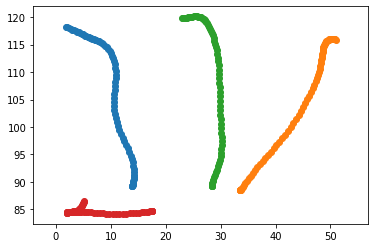

In [4]:
play_data = tracking_data[(tracking_data.play_id == 3227) & (tracking_data.game_id == 2020010500)]

snap_event = np.array(play_data[play_data.event_name == 'ball_snap']['time'])[0]

play_data = play_data[play_data.time >= snap_event]

skill_pos = ['WR','RB','TE','FB']

skill_pos_df =  play_data[play_data.position.isin(skill_pos) ]


player_name = skill_pos_df.gsisId.unique()

for player in player_name:
    temp_df = skill_pos_df[skill_pos_df.gsisId == player]
    plt.scatter(50-temp_df.y,temp_df.x)
plt.axis('equal')

# 2. Pass Block Win Rate

There is a metric developed by ESPN called [Pass Block Win Rate](https://www.espn.com/nfl/story/_/id/27584726/nfl-pass-blocking-pass-rushing-rankings-2019-pbwr-prwr-leaderboard) which measures how good is pass blocker/pass rusher. Their method is to use tracking data to construct a polygon around all offensive lineman, and if any defender enter the polygon within 2.5 seconds after snap it's considered as a pass rush win/pass block lost, and vice versa. Next is a simple snippet of recreating the metric and a visualization of the process

In [5]:

play_data = tracking_data[(tracking_data.play_id == 3086) & (tracking_data.game_id == 2020020200)]

snap_event = np.array(play_data[play_data.event_name == 'ball_snap']['time'])[0]

play_data = play_data[play_data.time >= snap_event]

OL_pos = ['T','C','G']

OL_pos_df =  play_data[play_data.position.isin(OL_pos) ]

defense_pos_df = play_data[play_data.IsOnOffense == False ]

offense_pos_df =  play_data[play_data.IsOnOffense == True ]

In [6]:
OL_coordinate_array = np.array(OL_pos_df.groupby('time').apply(lambda x: [np.array(x['x']), np.array(x['y'])]).apply(pd.Series))
offense_array = np.array(offense_pos_df.groupby('time').apply(lambda x: [np.array(x['x']), np.array(x['y'])]).apply(pd.Series))
defense_array = np.array(defense_pos_df.groupby('time').apply(lambda x: [np.array(x['x']), np.array(x['y'])]).apply(pd.Series))

In [7]:
def ccw_sort(p): #sort points counter clockwise
    p = np.array(p)
    mean = np.mean(p,axis=0)
    d = p-mean
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]

In [8]:
#Loop through first 25 frames (2.5 s) to determine pass rush win or lost

pass_rush_win = 0
pass_block_win_cutoff = 25
for frame in range(pass_block_win_cutoff ):
    if(pass_rush_win == 1):
        break
    oline_polygon = Polygon(ccw_sort(np.vstack(OL_coordinate_array[frame]).T))
    for def_player_coord in np.vstack(defense_array[frame]).T:
        if (oline_polygon.contains(Point(def_player_coord)) and pass_rush_win == 0):
            print("pass rush win at %1.2f s"% ((frame+1)*0.1))
            pass_rush_win = 1
    if(frame == pass_block_win_cutoff-1):
        print('pass block win before 2.5 s')

pass rush win at 1.90 s


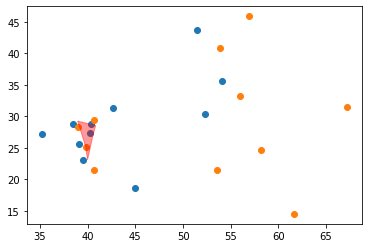

In [9]:
#Adding a red patch to offensive line polygon

ax = plt.subplot(111)
ax.scatter(np.vstack(offense_array[20]).T[:,0],np.vstack(offense_array[20]).T[:,1])
ax.scatter(np.vstack(defense_array[20]).T[:,0],np.vstack(defense_array[20]).T[:,1])
ring_patch = PolygonPatch(oline_polygon,alpha=0.4,color='red')
ax.add_patch(ring_patch)

# 3 Predict yards gain of rushing play

In [Kaggle big data bowl 2020 competition](https://www.kaggle.com/c/nfl-big-data-bowl-2020) competitors are asked to predict yards gain of a rushing play using a snapshot of data at handoff. The following code snippet use a model reproducing 1st place solution and can be [downloaded here](https://www.kaggle.com/takuok/1st-place-reproduction-10feats-dev)

In [10]:
play_df = tracking_data[(tracking_data.play_id == 1604) & (tracking_data.game_id == 2020010401)]

In [11]:
pbp_df = pd.read_csv('post_pbp_2019.csv') #merge to nflscrapR data

In [12]:
play_df = pd.merge(play_df,pbp_df[['game_id','play_id', 'rusher_player_id']])

In [13]:
play_df['x_s'] = play_df['s'] * np.cos((np.pi / 180) * play_df['dir'])
play_df['y_s'] = play_df['s'] * np.sin((np.pi / 180) * play_df['dir'])

play_df['IsRusher'] = play_df['gsisId'] == play_df['rusher_player_id']

In [14]:
handoff_frame = play_df[play_df.event_name == 'handoff']

In [15]:
def create_faetures(df):
    xysdir_o = df[(df.IsOnOffense == True) & (df.IsRusher == False)][['x','y','x_s','y_s']].values
    xysdir_rush = df[df.IsRusher == True][['x','y','x_s','y_s']].values
    xysdir_d = df[df.IsOnOffense == False][['x','y','x_s','y_s']].values
    
    off_x = np.array(df[(df.IsOnOffense == True) & (df.IsRusher == False)].groupby('play_id')['x'].apply(np.array))
    def_x = np.array(df[(df.IsOnOffense == False) ].groupby('play_id')['x'].apply(np.array))
    off_y = np.array(df[(df.IsOnOffense == True) & (df.IsRusher == False)].groupby('play_id')['y'].apply(np.array))
    def_y = np.array(df[(df.IsOnOffense == False) ].groupby('play_id')['y'].apply(np.array))
    off_sx = np.array(df[(df.IsOnOffense == True) & (df.IsRusher == False)].groupby('play_id')['x_s'].apply(np.array))
    def_sx = np.array(df[(df.IsOnOffense == False) ].groupby('play_id')['x_s'].apply(np.array))
    off_sy = np.array(df[(df.IsOnOffense == True) & (df.IsRusher == False)].groupby('play_id')['y_s'].apply(np.array))
    def_sy = np.array(df[(df.IsOnOffense == False) ].groupby('play_id')['y_s'].apply(np.array))
    

    player_vector = []
    for play in range(len(off_x)):
        player_feat = player_feature(off_x[play],def_x[play],off_y[play],def_y[play],off_sx[play],def_sx[play],
                                     off_sy[play],def_sy[play],xysdir_rush[play])
        player_vector.append(player_feat)
    
    return np.array(player_vector)

    
def player_feature(off_x,def_x,off_y,def_y,off_sx,def_sx,off_sy,def_sy,xysdir_rush):
    if(len(off_x)<10):
        off_x = np.pad(off_x,(10-len(off_x),0), 'mean' )
        off_y = np.pad(off_y,(10-len(off_y),0), 'mean' )
        off_sx = np.pad(off_sx,(10-len(off_sx),0), 'mean' )
        off_sy = np.pad(off_sy,(10-len(off_sy),0), 'mean' )
    if(len(def_x)<11):
        def_x = np.pad(def_x,(11-len(def_x),0), 'mean' )
        def_y = np.pad(def_y,(11-len(def_y),0), 'mean' )
        def_sx = np.pad(def_sx,(11-len(def_sx),0), 'mean' )
        def_sy = np.pad(def_sy,(11-len(def_sy),0), 'mean' )

    dist_def_off_x = def_x.reshape(-1,1)-off_x.reshape(1,-1)
    dist_def_off_sx = def_sx.reshape(-1,1)-off_sx.reshape(1,-1)
    dist_def_off_y = def_y.reshape(-1,1)-off_y.reshape(1,-1)
    dist_def_off_sy = def_sy.reshape(-1,1)-off_sy.reshape(1,-1)
    dist_def_rush_x = def_x.reshape(-1,1)-np.repeat(xysdir_rush[0],10).reshape(1,-1)
    dist_def_rush_y = def_y.reshape(-1,1)-np.repeat(xysdir_rush[1],10).reshape(1,-1)
    dist_def_rush_sx = def_sx.reshape(-1,1)-np.repeat(xysdir_rush[2],10).reshape(1,-1)
    dist_def_rush_sy = def_sy.reshape(-1,1)-np.repeat(xysdir_rush[3],10).reshape(1,-1)
    def_sx = np.repeat(def_sx,10).reshape(11,-1)
    def_sy = np.repeat(def_sy,10).reshape(11,-1)
    feats = [dist_def_off_x, dist_def_off_sx, dist_def_off_y, dist_def_off_sy, dist_def_rush_x, dist_def_rush_y,
            dist_def_rush_sx, dist_def_rush_sy, def_sx, def_sy]
    
    return np.stack(feats)

In [20]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class CnnModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(10, 128, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 160, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(160, 128, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.AdaptiveAvgPool2d((1, 11))

        self.conv2 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 160, kernel_size=(1, 1), stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(160),
            nn.Conv2d(160, 96, kernel_size=(1, 1), stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 96, kernel_size=(1, 1), stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(96),
        )
        self.pool2 = nn.AdaptiveAvgPool2d((1, 1))

        self.last_linear = nn.Sequential(
            Flatten(),
            nn.Linear(96, 256),
            nn.LayerNorm(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.last_linear(x)

        return x

model = CnnModel(num_classes=199)

model.load_state_dict(torch.load('exp1_reproduce_fold1.pth'))

<All keys matched successfully>

In [23]:
x = create_faetures(handoff_frame)
y_preds = torch.softmax(model(torch.tensor(x, dtype=torch.float32)), dim=1).float().detach().numpy()

In [24]:
print('Average yards gain of play = %1.2f' % np.sum(y_preds[0]*np.arange(-99,100)))

Average yards gain of play = 6.41


In [25]:
print('Chance of getting 20+ yards run = %1.2f%%'% (np.sum(y_preds[0][120:])*100))

Chance of getting 20+ yards run = 6.86%
